Test Accuracy: 0.9333
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       0.91      0.91      0.91        11
 Iris-virginica       0.86      0.86      0.86         7

       accuracy                           0.93        30
      macro avg       0.92      0.92      0.92        30
   weighted avg       0.93      0.93      0.93        30

Confusion Matrix:
[[12  0  0]
 [ 0 10  1]
 [ 0  1  6]]


<Figure size 800x600 with 0 Axes>

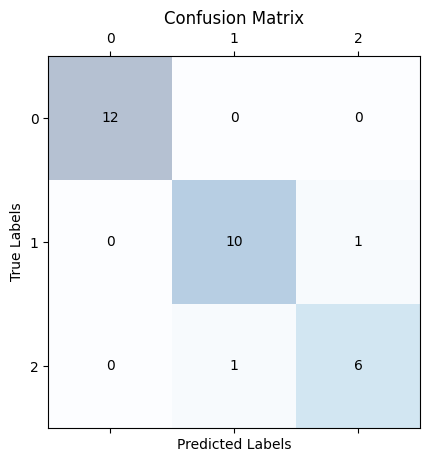

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Load data from CSV
data = pd.read_csv("/content/sample_data/iris.csv")

# Encode the class labels as integers: 0 -> Iris-setosa, 1 -> Iris-versicolor, 2 -> Iris-virginica
data['type'] = data['type'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})

# Extract the necessary columns excluding the product column
columns = ['x1', 'x2', 'x3', 'x4', 'type']
data_m = data[columns].to_numpy()

# Initialize variables
rows = data.shape[0]
cols = len(columns)
column = [1, 1, 1, 1]  # Flags for the four features

# Process data with median and normalization
def process_data_median(col):
    non_zero_values = data_m[data_m[:, col] != 0, col]
    median_value = np.median(non_zero_values)
    data_m[data_m[:, col] == 0, col] = median_value

def normalise(col):
    norm_col1 = data_m[:, col]
    min_v, max_v = np.min(norm_col1), np.max(norm_col1)
    data_m[:, col] = (norm_col1 - min_v) / (max_v - min_v)

# Applying processing and normalization based on the column flags
nb_col_a_1 = 0
for i in range(4):  # Process the four input columns
    if column[i] == 1:
        process_data_median(i)
        normalise(i)
        nb_col_a_1 += 1

# Use train_test_split to split the data into training and testing sets
X_train, X_test = train_test_split(data_m, test_size=0.2)

# Set the training and testing rows
rows_tr = X_train.shape[0]

# Initialize weights for the perceptron
nb_classes = 3
nb_features = nb_col_a_1 + 1  # 4 features + 1 product term
theta = np.random.rand(nb_features + 1, nb_classes)  # (5 features + bias, 3 classes)

# Softmax function for multi-class classification
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=1, keepdims=True)

# Perceptron training function with softmax output
def perceptron(lr, epochs, theta1):
    for epoch in range(epochs):
        for i in range(rows_tr):
            x = X_train[i, :nb_col_a_1]  # Select the 4 input features for the i-th training sample
            Prod = np.prod(x)   # Calculate the product of x1, x2, x3, x4
            inputs = np.append(x, Prod)  # Combine features and product into one vector

            y_true = int(X_train[i, -1])  # Get the true class label

            # Calculate the output using softmax
            logits = np.dot(inputs, theta[:-1]) + theta1[-1]  # Adjust weight updates accordingly
            y_hat = softmax(logits.reshape(1, -1)).flatten()

            # One-hot encode the true label
            y_true_one_hot = np.zeros(nb_classes)
            y_true_one_hot[y_true] = 1

            # Calculate the error (difference between predicted and actual)
            error = y_true_one_hot - y_hat

            # Update weights for the input features and product
            theta[:-1] += lr * np.outer(inputs, error)  # Update weights for x1, x2, x3, x4, and product term

            # Update the bias term
            theta[-1] += lr * error  # Update the bias term for each class

        # Evaluate and print metrics after each epoch
        y_train_pred = predict(X_train[:, :nb_col_a_1], theta)
        train_accuracy = accuracy_score(X_train[:, -1], y_train_pred)
        #print(f"Epoch {epoch+1}/{epochs} - Training Accuracy: {train_accuracy:.4f}")
        #print(theta[nb_col_a_1+1])

# Prediction function
def predict(X, theta):
    # Calculate the product of features for each sample and append it
    Prod = np.prod(X[:, :nb_col_a_1], axis=1).reshape(-1, 1)
    inputs = np.hstack([X[:, :nb_col_a_1], Prod])  # Combine the features with the product term
    logits = np.dot(inputs, theta[:-1]) + theta[-1]
    y_hat = softmax(logits)
    return np.argmax(y_hat, axis=1)

# Run the perceptron
perceptron(0.01, 100, theta)

# Evaluate on test data
y_test_pred = predict(X_test[:, :4], theta)
test_accuracy = accuracy_score(X_test[:, -1], y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Display the classification report
target_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
print(classification_report(X_test[:, -1], y_test_pred, target_names=target_names, labels=[0, 1, 2]))

# Confusion Matrix
conf_matrix = confusion_matrix(X_test[:, -1], y_test_pred, labels=[0, 1, 2])
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i, s=conf_matrix[i, j], ha='center', va='center')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

